# Spectral X-ray CT

We will write a projector for polychromatic X-ray CT in less than 20 lines of code using ODL!

## Contents
- Mathematical model of monochromatic X-ray CT
- Model of spectral CT with integrating detector
- Spectral CT model with multiple energy bins
- Implementation

## Mathematical model of monochromatic CT

The most used model for X-ray computed tomography is based on the *Beer-Lambert* law: When a monochromatic ray of photons hits a homogeneous target of thickness $d$, intensities follow the relation

$$
    I = I_0 \exp\left(-\frac{\mu}{\rho}\, \lambda\right),
$$

where

- $I_0$ is the intensity (photons per unit area) of the X-ray beam before hitting the object,
- $I$ is the intensity after passing through the object,
- $\mu/\rho$ is the *mass attenuation coefficient* of the material, and
- $\lambda = \rho\, d$ is the density-scaled thickness.

The density is introduced above since typically, values of $\mu/\rho$ are tabulated.

For inhomogeneous materials, the factor $(\mu/\rho)\lambda$ is replaced by the integral of the density-weighted attenuation coefficient $\mu$ along the ray $\ell$:

$$
    I = I_0 \exp\left(-\int_\ell \mu \mathrm{d}s \right)
$$

Here, $\mu$ is a function of position, $\mu = \mu(x)$. The task of CT is now to find $\mu$ from measurements of $I=I(\ell)$ for a number of rays $\ell$.

Clearly, this model can be linearized in terms of $\mu$ by the transformation

$$
    \log(I_0) - \log(I) = \int_\ell \mu \mathrm{d}s.
$$

For the collection of such line integrals, we use the notation

$$
    R\mu(\ell) = \int_\ell \mu \mathrm{d}s\quad \text{for all available }\ell.
$$

The *operator* $R$, i.e., the mapping that takes a function $\mu = \mu(x)$ and produces a function $R\mu = R\mu(\ell)$,
is called *ray transform*. The set of available lines is an important part of the model, but we keep it generic at this point.

## Spectral CT with integrating detector

Why is the previous section referring to "monochromatic" X-ray CT?

It is well-known from physics that attenuation depends strongly on the photon energy. In particular, a photon of energy $E$ will experience an attenuation of 

$$
    \mu = \mu(E, x)
$$

at a point $x$. Furthermore, X-ray sources produce photons of a wide range of energies with varying proportions. This distribution of energies emitted by the source is usually called *source spectrum*. An example is shown below:



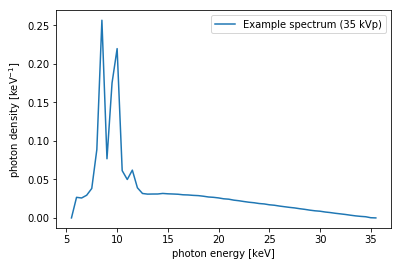

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

source_spectrum = np.load('./data/source_spectrum.npy')
plt.plot(source_spectrum[:, 0], source_spectrum[:, 1], label='Example spectrum (35 kVp)')
plt.xlabel('photon energy [keV]')
plt.ylabel('photon density [keV${}^{-1}$]')
plt.legend()

Now a detector that only counts photons irrespective of energy integrates over incoming photon energies:

$$
    I = \int_0^{E_\text{max}} \sigma(E)\, \exp\left(- R[\mu(E, \cdot)] \right)\, \mathrm{d}E,
$$

where $\sigma$ is the above function multiplied by the number $I_0$ of emitted photons per unit area.

Hence, the photons are attenuated differently at different energies, and the detector collapses the contributions of all energies into one final intensity (per detector pixel).

Now the assumption of monochromaticity in the previous section states that the X-ray source will produce only photons of a single energy $\bar E$ (and that detected photons do not lose energy while passing through the object). In this case, it is $\sigma(E) = I_0\delta(E - \bar E)$, and the above equation collapses into the simple monochromatic model.

### Dimension reduction

For an early assessment as to whether the problem of retrieving $\mu$ from $I$ will be tractable, let us have a rough look at equations vs. unknowns.

From single-energy X-ray CT we know that given enough projections and some further conditions, we can reconstruct the attenuation $\mu$ from inensity measurements $I$. However, in the spectral problem, $\mu$ has an additional dimension (energy), but we still have the same amount of data. Thus, we cannot expect to be able to find the energy-dependent attenuation. Furthermore, to find $\mu(E, x)$ at all energies $E$, we would need a separate (independent) measurement for each energy, which is also impractical.

A popular approach to reduce the problem size is to make a low-dimensional ansatz for $\mu$, in the form

$$
    \mu(E, x) = \sum_{m=1}^M \nu_m(E)\, f_m(x),
$$

with $M$ small, e.g. $M=3$.
Instead of having one "channel" per energy (which needs to be large enough to resolve the source spectrum), we now have only $M$ unknown spatially varying functions.

A possible interpretation of this separable ansatz is that each $m$ represents a material, $f_m$ is the density of the material, and $\nu_m$ is the attenuation curve for that material. These attenuation curves are available for a wide range of materials, i.e., if we choose the material composition beforehand, these functions are known.

The model for spectral CT with $M$ known materials is thus

$$
    I = \int_0^{E_{\text{max}}} \sigma(E)\, \exp\left(-\sum_{m=1}^M \nu_m(E)\, Rf_m \right)\, \mathrm{d}E.
$$

### Energy discretization

For a numerical implementation, we need to express the energy integral as a sum. To allow for non-uniform sampling later, we use the integration formula

$$
    \int_a^b f(x)\, \mathrm{d}x \approx
    (x_2 - x_1) f(x_1) + (x_N - x_{N-1}) f(x_N) +
    \sum_{n=2}^{N-1} \frac{x_{n+1} - x_{n-1}}{2} f(x_n)
$$

for sampling points $x_1, \dots, x_N$.

This yields the final model for single-bin spectral X-ray CT:

$$
    I = \sum_{n=1}^N \Delta E_n\, \sigma(E_n)\, \exp\left(-\sum_{m=1}^M \nu_m(E_n)\, Rf_m \right), \\
    %
    \Delta E_n =
    \begin{cases}
        E_2 - E_1               & \text{if } n = 1, \\
        E_N - E_{N-1}           & \text{if } n = N, \\
        (E_{n+1} - E_{n-1}) / 2 & \text{otherwise}.
    \end{cases}
$$

### Product space operators

Product space operators are a convenient way of expressing mappings that take a number of inputs at a time, and produce a (different) number of outputs at a time, irrespective of the types of inputs.

For instance, a matrix $A \in \mathbb{R}^{m \times n}$ can be seen as a mapping $\mathbb{R}^n \to \mathbb{R}^m$, where the inputs are *stacks of real numbers*. In other words, $A$ acts on the product space $\mathbb{R}^n = \underbrace{\mathbb{R} \times \dots \times \mathbb{R}}_{n \text{ times}}$ and maps to the product space $\mathbb{R}^m = \underbrace{\mathbb{R} \times \dots \times \mathbb{R}}_{m \text{ times}}$.

Now, this can be generalized: each of the "$\mathbb{R}$" space components can be replaced by an arbitrary vector space, and the entries of the matrix can be arbitrary operators $A_{i,j}: X_{i,j} \to Y_{i,j}$, forming the *operator matrix*

$$
    A =
    \begin{pmatrix}
        A_{1,1} & \cdots & A_{1,n} \\
        \vdots  & \ddots & \vdots  \\
        A_{m,1} & \cdots & A_{m,n}
    \end{pmatrix}
$$

Applying this matrix to a vector of "stacked" elements is as in matrix multiplication: For $F = (f_1, \dots, f_n)$ we have

$$
    (A(F))_i = \sum_{j=1}^n A_{i,j}(f_j), \quad i=1, \dots, m.
$$

There are two requirements for this sum to make sense:

1. **All operators in a column must take inputs from the same space.**
   This follows from the fact that all operators $A_{i,j}$ will process the same input $f_j$.

2. **All operators in a row must produce outputs in the same space.**
   This is because these outputs are being summed up, so they must be in the same space.
   
These rules result in the mapping

$$
    A =
    \begin{pmatrix}
        A_{1,1} & \cdots & A_{1,n} \\
        \vdots  & \ddots & \vdots  \\
        A_{m,1} & \cdots & A_{m,n}
    \end{pmatrix}
    : X_1 \times \dots \times X_n \to Y_1 \times \dots \times Y_m, \qquad
    %
    A_{i,j} : X_j \to Y_i.
$$

**Important:**

The *derivative* and *adjoint* (of the derivative) properties can be derived from the properties of the individual operators:

$$
    A'(F) = 
    \begin{pmatrix}
        A_{1,1}'(f_1) & \cdots & A_{1,n}'(f_n) \\
        \vdots        & \ddots & \vdots        \\
        A_{m,1}'(f_1) & \cdots & A_{m,n}'(f_n)
    \end{pmatrix}
    : X_1 \times \dots \times X_n \to Y_1 \times \dots \times Y_m,
$$

and (assuming linear $A_{i,j}$)

$$
    A^* =
    \begin{pmatrix}
        A_{1,1}^* & \cdots & A_{m,1}^* \\
        \vdots    & \ddots & \vdots  \\
        A_{1,n}^* & \cdots & A_{m,n}^*
    \end{pmatrix}
    : Y_1 \times \dots \times Y_m \to X_1 \times \dots \times X_n.
$$

This makes product space operators a convenient and powerful tool for expressing complicated functional relations in a compact way.

---

Let us look at some special patterns that are relevant for our case:

#### Diagonal operator

The diagonal pattern is the simplest one. There are $n$ inputs, $n$ outputs and $n$ operators $A_j$, and the $j$-th operator is applied to the $j$-th input, producing the $j$-th output:

$$
    A =
    \text{diag}(A_1, \dots, A_n) =
    \begin{pmatrix}
        A_1    & 0      & \cdots & 0      \\
        0      & \ddots &        & \vdots \\
        \vdots &        & \ddots & 0      \\
        0      & \cdots & 0      & A_{m,n}
    \end{pmatrix}
    : X_1 \times \dots \times X_n \to X_1 \times \dots \times X_n, \qquad
    %
    A(F) =
    \begin{pmatrix}
        A_1(f_1) \\
        \vdots   \\
        A_n(f_n)
    \end{pmatrix}.
$$

#### Broadcast operator

The broadcasting pattern (*one-to-many*) corresponds to a matrix with one column. There are 1 input, $m$ outputs and $m$ operators, each of which is applied to the single input:

$$
    A =
    \text{bcast}(A_1, \dots, A_m) =
    \begin{pmatrix}
        A_1    \\
        \vdots \\
        A_m
    \end{pmatrix}
    : X \to Y_1 \times \dots \times Y_m, \qquad
    %
    A(f) =
    \begin{pmatrix}
        A_1(f) \\
        \vdots \\
        A_m(f)
    \end{pmatrix}.
$$

#### Reduction operator

The reduction pattern (*many-to-one*) does the opposite of broadcasting. It corresponds to a matrix with one row, and it sums the outputs of all $n$ operators into a single result:

$$
    A =
    \text{reduce}(A_1, \dots, A_n) =
    \begin{pmatrix}
        A_1 & \cdots & A_n
    \end{pmatrix}
    : X_1 \times \dots \times X_n \to Y, \qquad
    %
    A(F) = \sum_{j=1}^n A_j(f_j).
$$


### Reformulating the model


Let us now write the spectral CT model using these new notions. We start with the sum in the exponential,

$$
    -\sum_{m=1}^M \nu_m(E_n)\, Rf_m.
$$

Reading from right to left, the first step is to apply the ray transform $R$ to all $M$ inputs $f_m$.

**Quiz:** Which pattern will we use?



**Answer:**

We make a *diagonal operator* since we have the same number of inputs as outputs, and each one just "sees" one operator:

$$
    P = \text{diag}(\underbrace{R, \dots, R}_{m \text{ times}}) = \text{diag}(R, M): X^M \to Y^M, \qquad
    P(F) =
    \begin{pmatrix}
        R(f_1) \\
        \vdots
        R(f_m)
    \end{pmatrix},
    \quad F = (f_1, \dots, f_M) \in X^M.
$$

Here we use the shorthand notation $X^M = \underbrace{X \times \dots \times X}_{m \text{ times}}$ and $\text{diag}(R, M)$ as accordingly to repeat the same space or operator $M$ times, respectively.

To rewrite the sum, we observe that we have $M$ inputs that are summed up with weights $\nu_m(E_n)$, but since the weights depend on the index $n$ as well, we have one output for each such $n$, totalling in $N$ outputs. Thus, the summation is really an operation $Y^M \to Y^N$.

**Quiz:** Which pattern do we need to use here? What are the operators?


**Answer:**


There's no special case here, we just make a *product space operator*, where the entry at index $(n, m)$ is the *multiplication operator*

$$
    D_a : Y \to Y, \quad D_a(g) = a \cdot g
$$

with $a_{n,m} = -\nu_m(E_n)$ (to have the minus sign already covered):

$$
    W =
    \begin{pmatrix}
        D_{a_{1,1}} & \cdots & D_{a_{1,N}} \\
        \vdots      & \ddots & \vdots      \\
        D_{a_{M,1}} & \cdots & D_{a_{M,N}}
    \end{pmatrix}
    : Y^M \to Y^N.
$$

This allows us to express the sum compactly as

$$
    -\sum_{m=1}^M \nu_m(E_n)\, Rf_m = \big[ W\big( P(F) \big) \big]_n.
$$

In the next step, the exponential of these sums is taken.

**Quiz:** Pattern? Spaces?


**Answer:**

This mapping can only be a *diagonal operator* since we simply apply the same operation on each input, producing the same number $N$ of outputs:

$$
    U = \text{diag}(\exp, N): Y^N \to Y^N, \qquad
    U(G) =
    \begin{pmatrix}
        \exp(g_1) \\
        \vdots    \\
        \exp(g_N)
    \end{pmatrix},
$$

where the application of $\exp$ is to be understood pointwise (**Remember:** the $g_n$ are elements in the range of $R$, i.e., *sinograms* in 2D).

Finally, all the ouputs of the previous step need to be summed up with weights $\sigma(E_n)$ to yield the final intensity:

$$
    I = \sum_{n=1}^N \Delta E_n\, \sigma(E_n)\, \exp\left(-\sum_{m=1}^M \nu_m(E_n)\, Rf_m \right).
$$

**Quiz:** Which pattern and operators to take for this step?

**Answer:**

We reduce to a single output and scale by factors $b_n = \Delta E_n\, \sigma(E_n)$, so this is a *reduction* pattern with *multiplication operators* as in the previous sum:

$$
    S = \text{reduce}(D_{b_1}, \dots, D_{b_N}): Y^N \to Y, \qquad
    S(G) = \sum_{n=1}^N b_n\, g_n.
$$


#### Result

Now we can express the complete model as a composition of four mappings:

$$
    I = S \Big[ U\big[ W\big( P(F) \big) \big] \Big],
$$

or short

$$
    I = A(F), \quad A = S \circ U \circ W \circ P: X^M \to Y.
$$

## Implementation

Finally, code!

It turns out that this whole machinery of operators and product spaces can be very succinctly expressed in terms of built-in ODL functionality. We can, as a first attempt, write a *Python function* that takes an `Operator` $R$, the coefficients $\nu_m(E_n)$ and $\sigma(E_n)$, and returns the full spectral projector:

In [2]:
def spectral_projector(ray_trafo, energies, source_spectrum, material_spectra):
    """Create a projection operator for spectral CT."""

Note that `ray_trafo` can be any type of ray transform (actually any operator), in particular do we not specify the geometry since it is not relevant at this point.

To fill this function with life, we can use the following ODL functionality:

- $P = \text{diag}(R, M)$ --> `odl.DiagonalOperator(ray_trafo, M)` -- `ray_trafo` is given and `M = len(material_spectra)` (number of materials)

- $W =$ matrix of multiplication operators --> `odl.ProductSpaceOperator(op_matrix)` -- the matrix being an array of `odl.ScalingOperator` objects

- $\exp$ pointwise --> `odl.ufunc_ops.exp` -- "ufunc" (universal function) is a NumPy term for functions evaluated on all array elements

- $S = \text{reduce}(D_{b_1}, \dots, D_{b_n})$ --> `odl.ReductionOperator(*scaling_ops)`, where `scaling_ops` is a list of `odl.ScalingOperator` objects

Here's the step-by-step implementation, interleaved with the mathematical counterparts:

In [ ]:
import odl
import numpy as np

def spectral_projector(ray_trafo, energies, source_spectrum, material_spectra):
    """Create a projection operator for spectral CT."""
    # Set short-hand parameters and check inputs
    M = len(material_spectra)
    N = len(energies)
    assert source_spectrum.shape == (N,)
    assert all(nu.shape == (N,) for nu in material_spectra)
    
    # Space for scaling operators
    Y = ray_trafo.range
    
    # The integration weights for the energy integral
    energy_weights = np.empty_like(energies)
    energy_weights[1:-1] = (energies[2:] - energies[:-2]) / 2
    energy_weights[0] = energies[1] - energies[0]
    energy_weights[-1] = energies[-1] - energies[-2]

#### 1. $P = \text{diag}(R, M)$

In [4]:
def spectral_projector(ray_trafo, energies, source_spectrum, material_spectra):
    ...
    
    P = odl.DiagonalOperator(ray_trafo, M)

#### 2. $$
       W =
       \begin{pmatrix}
           D_{a_{1,1}} & \cdots & D_{a_{1,N}} \\
           \vdots      & \ddots & \vdots      \\
           D_{a_{M,1}} & \cdots & D_{a_{M,N}}
       \end{pmatrix},
       \qquad
       a_{m,n} = -\nu_m(E_n)
   $$

In [5]:
def spectral_projector(ray_trafo, energies, source_spectrum, material_spectra):
    ...
    
    W_matrix = np.empty((N, M), dtype=object)  # to store arbitrary Python objects
    for n in range(N):  # N and M are "small", so looping is OK
        for m in range(M):
            W_matrix[n, m] = odl.ScalingOperator(scalar=-material_spectra[m][n], domain=Y)
    
    W = odl.ProductSpaceOperator(W_matrix)

#### 3. $U = \text{diag}(\exp, N)$

In [6]:
def spectral_projector(ray_trafo, energies, source_spectrum, material_spectra):
    ...
    
    exp = odl.ufunc_ops.exp(Y)
    U = odl.DiagonalOperator(exp, N)

#### 4. $S = \text{reduce}(D_{b_1}, \dots, D_{b_N}), \quad b_n = \Delta E_n \sigma(E_n)$

In [7]:
def spectral_projector(ray_trafo, energies, source_spectrum, material_spectra):
    ...
    
    S_row = [odl.ScalingOperator(scalar=energy_weights[i] * source_spectrum[i], domain=Y)
             for i in range(N)]
    S = odl.ReductionOperator(*S_row)

#### 5. Compose and return

In [8]:
def spectral_projector(ray_trafo, energies, source_spectrum, material_spectra):
    ...
    
    return S * U * W * P

**Done!**

Here's the full code:

In [9]:
import odl
import numpy as np

def spectral_projector(ray_trafo, energies, source_spectrum, material_spectra):
    """Create a projection operator for spectral CT."""
    # Set short-hand parameters and check inputs
    M = len(material_spectra)
    N = len(energies)
    assert source_spectrum.shape == (N,)
    assert all(nu.shape == (N,) for nu in material_spectra)
    
    # Space for scaling operators
    Y = ray_trafo.range
    
    # The integration weights for the energy integral
    energy_weights = np.empty_like(energies)
    energy_weights[1:-1] = (energies[2:] - energies[:-2]) / 2
    energy_weights[0] = energies[1] - energies[0]
    energy_weights[-1] = energies[-1] - energies[-2]
    
    P = odl.DiagonalOperator(ray_trafo, M)
    
    W_matrix = np.empty((N, M), dtype=object)  # to store arbitrary Python objects
    for n in range(N):  # N and M are "small", so looping is OK
        for m in range(M):
            W_matrix[n, m] = odl.ScalingOperator(scalar=-material_spectra[m][n], domain=Y)
    
    W = odl.ProductSpaceOperator(W_matrix)
    
    exp = odl.ufunc_ops.exp(Y)
    U = odl.DiagonalOperator(exp, N)

    S_row = [odl.ScalingOperator(scalar=energy_weights[i] * source_spectrum[i], domain=Y)
             for i in range(N)]
    S = odl.ReductionOperator(*S_row)   
    
    return S * U * W * P

## A complete example

Now we add the missing parts like retrieving spectra, defining a ray transform etc.

First some imports, including the [`physdata`](https://github.com/Dih5/physdata) module for retrieving attenuation coefficients from NIST.

In [10]:
! pip install https://github.com/Dih5/physdata/archive/master.zip

    100% |████████████████████████████████| 256kB 724kB/s ta 0:00:01


In [11]:
% matplotlib inline
import csv
import matplotlib.pyplot as plt
import numpy as np
import physdata.xray
import odl
import scipy.interpolate

We download mass attenuation coefficients (unit $[\text{cm}^2 / \text{g}]$) of bone, soft tissue and water from NIST to make a phantom. The density values (unit $[\text{g} / \text{cm}^3]$) are from "the internet".

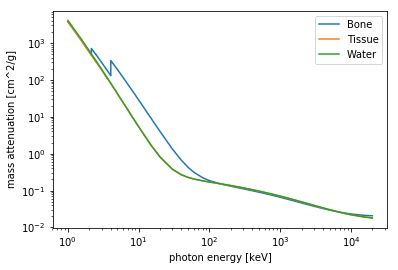

In [12]:
bone_att = np.array(physdata.xray.fetch_coefficients('bone'))[:, :2]  # [cm^2/g]
bone_att[:, 0] *= 1000  # [MV -> kV]
bone_dens = 1.9  # [g/cm^3]

tissue_att = np.array(physdata.xray.fetch_coefficients('tissue'))[:, :2]  # [cm^2/g]
tissue_att[:, 0] *= 1000  # [MV -> kV]
tissue_dens = 0.91  # [g/cm^3]

water_att = np.array(physdata.xray.fetch_coefficients('water'))[:, :2]  # [cm^2/g]
water_att[:, 0] *= 1000  # [MV -> kV]
water_dens = 1.0  # [g/cm^3]

# Alternative: load stored files
# bone_att = np.load('./data/bone_attenuation.npy')
# tissue_att = np.load('./data/tissue_attenuation.npy')
# water_att = np.load('./data/water_attenuation.npy')

plt.figure()
plt.loglog(bone_att[:, 0], bone_att[:, 1], label='Bone')
plt.loglog(tissue_att[:, 0], tissue_att[:, 1], label='Tissue')
plt.loglog(water_att[:, 0], water_att[:, 1], label='Water')
plt.legend()
plt.xlabel('photon energy [keV]')
plt.ylabel('mass attenuation [cm^2/g]')
plt.show()

Next we read a source spectrum obtained from an [online simulator tool](https://www.oem-xray-components.siemens.com/x-ray-spectra-simulation), using a Tungsten target with 35 kVp and 0.1 mm aluminium filter. The given values are relative photon flux densities (unit $[\text{mm}^{-2}]$), integrating to 1.

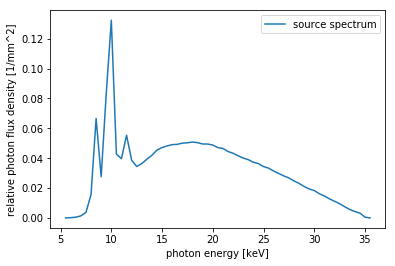

In [13]:
spectrum_file = './data/source_spectrum_0.1mm_AL_1m_air.csv'
with open(spectrum_file) as f:
    lines = f.readlines()
    lines = [line.replace(',', '.') for line in lines]  # Comma decimal marker -> dot
    lines.insert(0, 'keV;photon_density\n')  # Manually add column labels

dialect = csv.Sniffer().sniff(lines[0], delimiters=';')
reader = csv.DictReader(lines, dialect=dialect)

energies = np.empty(len(lines) - 1)
photon_dens = np.empty(len(lines) - 1)
for i, row in enumerate(reader):
    energies[i] = float(row['keV'])
    photon_dens[i] = float(row['photon_density'])  # [mm^(-2)]

# Alternative: load stored file
# source_spectrum = np.load('./data/source_spectrum.npy')
# energies = source_spectrum[:, 0]
# photon_dens = source_spectrum[:, 1]

plt.figure()
plt.plot(energies, photon_dens, label='source spectrum')
plt.legend()
plt.xlabel('photon energy [keV]')
plt.ylabel('relative photon flux density [1/mm^2]')
plt.show()

Next we interpolate the material spectra at the given energy values:

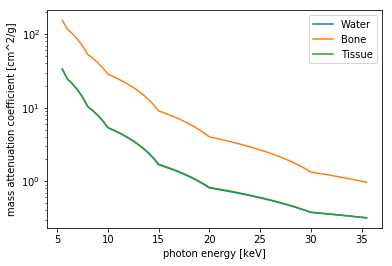

In [14]:
x, y = water_att[:, 0], water_att[:, 1]
water_spectrum = scipy.interpolate.interp1d(x, y)(energies)
x, y = bone_att[:, 0], bone_att[:, 1]
bone_spectrum = scipy.interpolate.interp1d(x, y)(energies)
x, y = tissue_att[:, 0], tissue_att[:, 1]
tissue_spectrum = scipy.interpolate.interp1d(x, y)(energies)

plt.figure()
plt.semilogy(energies, water_spectrum, label='Water')
plt.semilogy(energies, bone_spectrum, label='Bone')
plt.semilogy(energies, tissue_spectrum, label='Tissue')
plt.xlabel('photon energy [keV]')
plt.ylabel('mass attenuation coefficient [cm^2/g]')
plt.legend()
plt.show()

Now we build a phantom from these materials. The phantom will consist of 3 components, that correspond to the separate densities of bone, tissue and water, respectively. We use a simple Shepp-Logan type phantom to keep things short.

ODL provides a tool for creating a phantom from a specification of ellipses. It adds the contribution of all ellipses with provided values, locations, half axes and orientations. We first need to specify in which spatial region and with how many points per axis we want to discretize the phantom. Then we make the separate phantoms my modifying the Shepp-Logan ellipses.

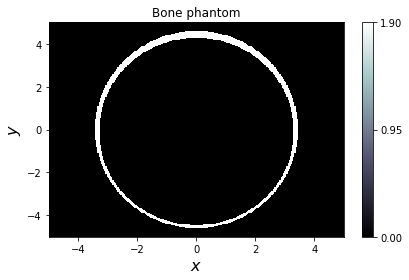

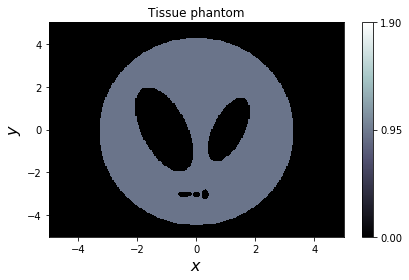

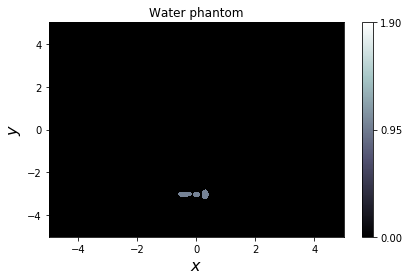

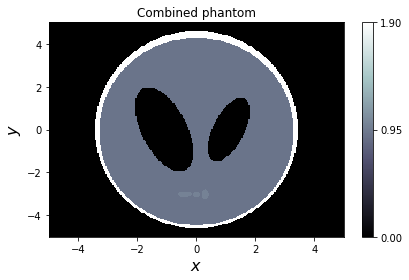

In [15]:
# Reconstruction volume: square of 10 cm side length
reco_space = odl.uniform_discr([-5, -5], [5, 5], (256, 256), dtype='float32')

# Get Shepp-Logan ellipses, a list of lists where each sublist specifies
# one ellipse
shepp_logan_ellipses = odl.phantom.transmission.shepp_logan_ellipsoids(
    2, modified=True)

# Bone: outer shell from ellipses 0 and 1
bone_indices = [0, 1]
bone_ellipses = [list(shepp_logan_ellipses[i]) for i in bone_indices]
bone_ellipses[0][0] = bone_dens
bone_ellipses[1][0] = -bone_dens
bone_phantom = odl.phantom.ellipsoid_phantom(reco_space, bone_ellipses)

# Soft tissue: inner part, removing the 2 big tilted ellipses and the
# 3 small ellipses on the bottom
tissue_indices = [1, 2, 3, 7, 8, 9]
tissue_ellipses = [list(shepp_logan_ellipses[i]) for i in tissue_indices]
tissue_ellipses[0][0] = tissue_dens
tissue_ellipses[1][0] = -tissue_dens
tissue_ellipses[2][0] = -tissue_dens
tissue_ellipses[3][0] = -tissue_dens
tissue_ellipses[4][0] = -tissue_dens
tissue_ellipses[5][0] = -tissue_dens
tissue_phantom = odl.phantom.ellipsoid_phantom(reco_space, tissue_ellipses)

# Water: 3 small ellipses on the bottom
water_indices = [7, 8, 9]
water_ellipses = [list(shepp_logan_ellipses[i]) for i in water_indices]
water_ellipses[0][0] = water_dens
water_ellipses[1][0] = water_dens
water_ellipses[2][0] = water_dens
water_phantom = odl.phantom.ellipsoid_phantom(reco_space, water_ellipses)

bone_phantom.show('Bone phantom', clim=[0, 1.9])
tissue_phantom.show('Tissue phantom', clim=[0, 1.9])
water_phantom.show('Water phantom', clim=[0, 1.9])
_ = (bone_phantom + tissue_phantom + water_phantom).show('Combined phantom', clim=[0, 1.9])

Now we generate an example geometry (parallel beam 2D) and the corresponding ray transform. We use 180 angles and a detector with 384 pixels (matches the volume pixel size):

In [16]:
angle_part = odl.uniform_partition(0, np.pi, 180)
detector_part = odl.uniform_partition(-7.5, 7.5, 384)
geometry = odl.tomo.Parallel2dGeometry(angle_part, detector_part)
ray_trafo = odl.tomo.RayTransform(reco_space, geometry)

Finally we generate some data! To do that we create the spectral projector and call it on our 3-component phantom:

In [17]:
mean_photons_per_pixel = 1e4
source_spectrum = photon_dens * mean_photons_per_pixel
material_spectra = [bone_spectrum, tissue_spectrum, water_spectrum]
fwd_op = spectral_projector(
    ray_trafo, energies, source_spectrum, material_spectra)

# Checking domain and range
print(repr(fwd_op.domain))
print(repr(fwd_op.range))

ProductSpace(uniform_discr([-5., -5.], [ 5.,  5.], (256, 256), dtype='float32'), 3)
uniform_discr([ 0. , -7.5], [ 3.1416,  7.5   ], (180, 384), dtype='float32')


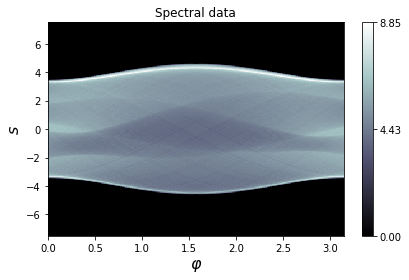

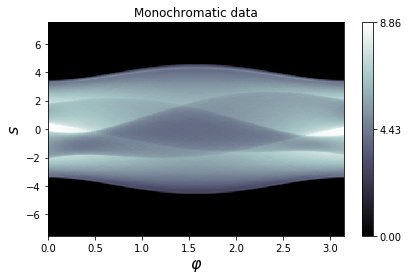

In [18]:
spectral_data = fwd_op([bone_phantom, tissue_phantom, water_phantom])
# To see something, apply log transform
log_spectral_data = np.log(mean_photons_per_pixel) - np.log(spectral_data)
_ = (log_spectral_data).show('Spectral data')

# For comparison the monochromatic data
log_mono_data = ray_trafo(bone_phantom + tissue_phantom + water_phantom)
_ = log_mono_data.show('Monochromatic data')

To see the beam hardening effect in action, we compute a simple FBP reconstruction from the data (assuming a linear monochromatic model):

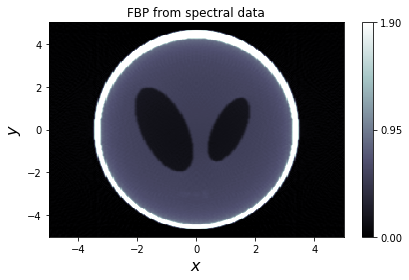

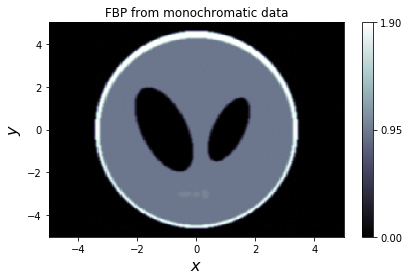

In [19]:
# Create a quick FBP reco operator
fbp_op = odl.tomo.fbp_op(ray_trafo, filter_type='Hann', frequency_scaling=0.9)
_ = fbp_op(log_spectral_data).show('FBP from spectral data', clim=[0, 1.9])
_ = fbp_op(log_mono_data).show('FBP from monochromatic data', clim=[0, 1.9])

## Conclusions

- We have a machinery for creating a (presumably) realistic spectral projector from given spectra of source and materials.
- The difference between spectral and non-spectral data in our example is significant.
- The implementation is pretty compact and can, in principle, be used directly in numerical solvers since `derivative` and `adjoint` methods are defined automatically.

## Next steps

- The problem is non-linear and quite hard to optimize. A good strategy is required.
- The implementation works fine but seems to be quite slow. We should identify the bottlenecks!
- To speed things up, in particular later for the derivative and its adjoint, partial computations can be reused. This requires an implementation of the spectral projector as an `Operator` with manual overrides for `derivative` and `adjoint`.
- Currently, all energies from 0 to 35 keV are used with equal spacing. We should use less samples in the range after the source intensity peaks.
- For an energy-discriminating detector we need to handle the case of multiple energy bins, i.e., assign photon energy subsets to detector bins. This changes the operator structure a bit, but not too much.